In [1]:

import findspark
findspark.init()
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import CountVectorizer
import pandas as pd
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import Row
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover
import requests
from pyspark.ml.pipeline import PipelineModel
from bs4 import BeautifulSoup
import re
from pyspark import SparkContext
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
from pyspark.streaming import StreamingContext
import traceback
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, NumericType, ArrayType, DoubleType
import pandas as pd
import sys
from pyspark.sql import SQLContext, SparkSession
from nltk.corpus import stopwords
from operator import add
from pyspark import SparkContext
from pyspark import SparkConf


sc = SparkContext(appName  = 'test')


In [2]:

pattern = r'|'.join((r'@[A-Za-z0-9_]+', r'https?://[^ ]+'))
web = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')


# Import Saved pre trained  model/Pipeline
model =  PipelineModel.load('./trained_model/')

IP = "localhost"
Port = 9990

sqlContext = SQLContext(sc)
ssc = StreamingContext(sc, 20)



stop_words = list(stopwords.words('english'))


def clean( text):

    soup = BeautifulSoup(text)
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(pattern, '', bom_removed)
    stripped = re.sub(web, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    alphar = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = " ".join([x.lower() for x in tok.tokenize(alphar) if len(x) > 1 ])
    words = [x for x in words.split(' ') if not x in stop_words ]
    return (" ".join(words)).strip()



def infere(tweet_text):
    try:
        if not tweet_text.isEmpty():
            data_df = sqlContext.createDataFrame(tweet_text.collect()[0], StringType(), False)
            data_df = data_df.selectExpr("value as text")
            data_df.show()
            prediction = model.transform(data_df)
            prediction = prediction.select('text','prediction')
            prediction.show()
            return prediction.filter(prediction.text.isNotNull())
        
    except:
        import traceback
        e= traceback()
        print('exception', e)
    
def bigram(words):
    bigrams = []
    for i in range(len(words) - 1):
        bigrams.append((tuple(words[i:i+2]), 1))
    return bigrams



lines = ssc.socketTextStream(IP, Port) 
line = lines.map(lambda cleaned: clean(cleaned))
line = line.map(lambda line: line.split('mydelimiter'))
line2 = line.foreachRDD( lambda rdd_: infere( rdd_).write.csv("./out/", mode = 'append') if not rdd_.isEmpty() else None )




# Start the computation
ssc.start()             
# Wait for the computation to terminate
ssc.awaitTerminationOrTimeout(120)  

ssc.stop()

+--------------------+
|                text|
+--------------------+
|fair lot us stopp...|
|mask psyop danger...|
|the pandemic puni...|
|the government ad...|
| really single st...|
|well said sir pan...|
| sir police perso...|
|bruh hit postseas...|
|please note video...|
|dear honourable c...|
|here top lawn lan...|
| beer pub sector ...|
|as confirmed case...|
| know else would ...|
|will miss daytime...|
|at walgreens runn...|
| say numbers goin...|
| whitty talking d...|
|india two preciou...|
|                    |
+--------------------+

+--------------------+----------+
|                text|prediction|
+--------------------+----------+
|fair lot us stopp...|       0.0|
|mask psyop danger...|       1.0|
|the pandemic puni...|       1.0|
|the government ad...|       0.0|
| really single st...|       0.0|
|well said sir pan...|       1.0|
| sir police perso...|       0.0|
|bruh hit postseas...|       0.0|
|please note video...|       1.0|
|dear honourable c...|       1.0|
|here

In [3]:
from pyspark.sql import SparkSession
import pandas as pd

spark = SparkSession.builder.appName('test').getOrCreate()
df=spark.read.csv(
    "./out/*.csv",\
    header=False, mode = 'append')

df.printSchema()
df = df.selectExpr("_c0 as text", "_c1 as Score")


root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)



### Plot the top words 

In [4]:
negative_oc = df.filter(df.Score==0).withColumn('NegativeOccurencies', explode(split(col('text'), ' ')))\
    .groupBy('NegativeOccurencies')\
    .count()\
    .sort('count', ascending=False)

positive_oc = df.filter(df.Score==1).withColumn('PositiveOccurencies', explode(split(col('text'), ' ')))\
    .groupBy('PositiveOccurencies')\
    .count()\
    .sort('count', ascending=False)

In [5]:
print('Number of tweets classified as positive: {} \nNumber of tewwts classified as Negative: {}'.format(positive_oc.count(), negative_oc.count()))

Number of tweets classified as positive: 482 
Number of tewwts classified as Negative: 490


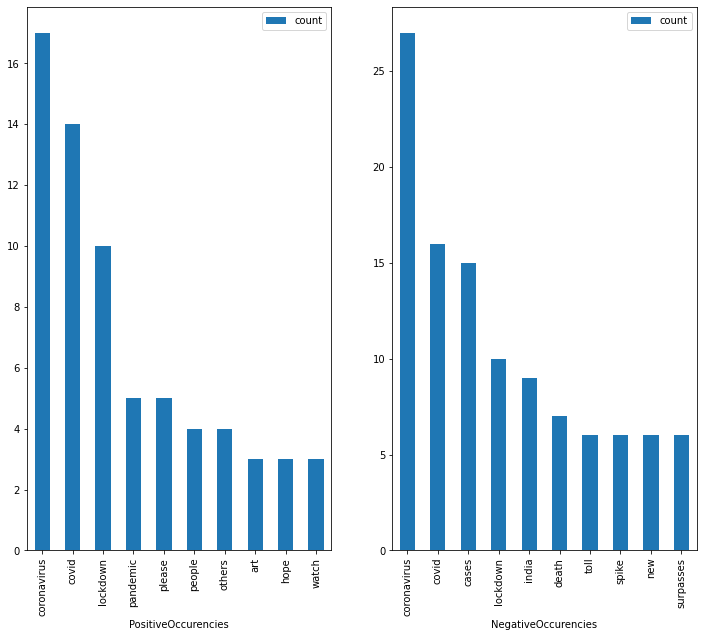

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12,10), nrows=1, ncols=2)
positive_oc.toPandas().head(10).plot.bar(x='PositiveOccurencies', y='count', ax = ax[0])
negative_oc.toPandas().head(10).plot.bar(x='NegativeOccurencies', y='count', ax=ax[1] )